_Aboa Bouadou, Rose Guionnet, Nathan Laîné, Victor Devys, Tino Margely_

## Import Modules

In [1]:
import pandas as pd
from datetime import datetime, timedelta

In [2]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import math
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib import pyplot as plt
import copy
import time
from pulp import *
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import seaborn as sns

In [3]:
SECONDS_PER_DAY = 24*60*60

## Read Data

In [4]:
data = pd.read_excel("data/raw/Orano-données-Single.xlsx", sheet_name="Optim", header=5, usecols=[3,4,5,6,7], nrows=47)

In [5]:
data.head()

,Commandes,ordre,disp,max,durée
0,c1,1,2021-01-01,2021-06-01,6.057056
1,c2,2,2021-02-01,2021-08-01,59.133726
2,c3,3,2021-03-01,2021-10-01,18.738048
3,c4,4,2021-04-01,2021-12-01,6.044729
4,c5,5,2021-05-01,2022-02-01,71.008938


In [6]:
data['disp'].min().to_pydatetime()

datetime.datetime(2021, 1, 1, 0, 0)

# Convert Excel to problem data

In [7]:
min_date = data['disp'].min().to_pydatetime()

In [8]:
(min_date + timedelta(12.6541)).strftime("%d/%m/%Y-%H:%M")

'13/01/2021-15:41'

In [9]:
def dataframe_to_list(data, min_date):
    dataframe = data.copy()
    #dataframe = dataframe
    dataframe['disp'] = dataframe['disp'].apply(lambda x: (x.to_pydatetime()- min_date).total_seconds()/SECONDS_PER_DAY)
    dataframe['max'] = dataframe['max'].apply(lambda x: (x.to_pydatetime()-min_date).total_seconds()/SECONDS_PER_DAY)
    dataframe['durée'] = dataframe['durée']
    
    return(list(dataframe['disp']),list(dataframe['max']),list(dataframe['durée']))

In [10]:
def scalar_to_day(scalar, min_date):
    return (min_date+timedelta(scalar)).strftime("%d/%m/%Y-%H:%M")

In [11]:
n = 15
disp, dmax, duree = dataframe_to_list(data, min_date)
disp, dmax, duree = disp[:n], dmax[:n], duree[:n]

In [12]:
print("Disp : " , disp[:5], "...")
print("Max : " , dmax[:5], "...")
print("Durée : " , duree[:5], "...")

Disp :  [0.0, 31.0, 59.0, 90.0, 120.0] ...
Max :  [151.0, 212.0, 273.0, 334.0, 396.0] ...
Durée :  [6.057056413817744, 59.13372606760222, 18.738048272122583, 6.044729107183509, 71.0089381707361] ...


In [13]:
def isFeasible(disp, dmax, duree):
    time = sum(duree)
    date_max_max = max(dmax)
    print("time sum : ", time)
    print("Date Max max : ", date_max_max)

In [14]:
isFeasible(disp, dmax, duree)

time sum :  729.4444821614793
Date Max max :  1003.0


## Première résolution

In [15]:
def solvePLNE(disp, dmax, duree):
    
    Tasks= list(range(len(disp))) #Liste des taches
    print("Tasks : ", Tasks)
    M = 100000
    
    model = LpProblem("Orano", LpMaximize)
    
    # Variables 
    x = LpVariable.dicts("x", ((i, j) for i in Tasks for j in Tasks),0,1,LpInteger) #x_{i,j}=1 si i est usinée avant j
    deb = LpVariable.dicts("deb", Tasks,0, None)
    dem = LpVariable.dicts("dem", Tasks,0, None)
    real = LpVariable.dicts("real", Tasks,0, None)
    marge = LpVariable.dicts("marge", Tasks,0, None)
    liv = LpVariable.dicts("liv", Tasks,0, None)
    z = LpVariable("z", lowBound=0)
    
    # Contraintes :
    for j in Tasks:
        model += x[j,j] == 0
        model += dem[j] >= disp[j]
        model += real[j] == dem[j] + duree[j]
        #
        #for i in Tasks:
        #    if i!=j:
        #        model += dem[j] >= real[i] - M*(1-x[i,j]) 
        model += dem[j] >= lpSum(duree[i]*x[i,j] for i in Tasks)
        model += liv[j] == deb[j] + 30
        model += liv[j] <= dmax[j]
        model += marge[j] == dmax[j] - liv[j]
        model += deb[j] >= real[j]
        model += z <= marge[j]
        for i in Tasks:
            if i != j:
                model += x[j,i] + x[i,j] == 1 
            
            for k in Tasks:
                if i!=j and i!=k and j!=k:
                    model += x[i,k] >= x[i,j] + x[j,k] - 1
    
    
    # Objectif : 
    model += z  
    
    #Resolution du PLNE : 
    starttime=time.time() #Pour avoir le temps d'execution
    #model.solve(PULP_CBC_CMD(maxSeconds=15))
    model.solve(PULP_CBC_CMD())
    solveTime=time.time()-starttime
    
    #Affichage des éléments de résolution
    f_val=[]
    for i in range(0,len(Tasks)):
        f_val.append(model.variables()[i].varValue)
    order=np.argsort(f_val)
    
        
    print("Temps de résolution = ", solveTime)
    print("Statut de la solution = ", LpStatus[model.status])
    print("Valeur optimale = ", value(model.objective))
    print("Ordre des taches =",order)
    for i in range(len(Tasks)):
        print(model.variables()[i], model.variables()[i].value())
    for i in range(len(Tasks),2*len(Tasks)):
        print(model.variables()[i], model.variables()[i].value())
    for i in range(2*len(Tasks),3*len(Tasks)):
        print(model.variables()[i], model.variables()[i].value())

    return(solveTime,value(model.objective),list(order))

In [16]:
solvePLNE(disp, dmax, duree)

Tasks :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Temps de résolution =  0.18104124069213867
Statut de la solution =  Optimal
Valeur optimale =  91.866274
Ordre des taches = [ 0  7  1  8 10  9 11 12  6 14 13  3  2  5  4]
deb_0 24.795105
deb_1 90.133726
deb_10 585.24349
deb_11 534.27211
deb_12 729.44448
deb_13 665.8627
deb_14 429.21543
deb_2 77.738048
deb_3 160.9825
deb_4 191.00894
deb_5 180.00649
deb_6 272.39739
deb_7 371.84169
deb_8 463.30558
deb_9 443.31978
dem_0 18.738048
dem_1 31.0
dem_10 534.27211
dem_11 463.30558
dem_12 665.8627
dem_13 585.24349
dem_14 424.0
dem_2 59.0
dem_3 154.93777
dem_4 120.0
dem_5 160.9825
dem_6 181.0
dem_7 271.40388
dem_8 443.31978
dem_9 377.05712
liv_0 54.795105
liv_1 120.13373
liv_10 615.24349
liv_11 564.27211
liv_12 759.44448
liv_13 695.8627
liv_14 459.21543
liv_2 107.73805
liv_3 190.9825
liv_4 221.00894
liv_5 210.00649
liv_6 302.39739
liv_7 401.84169
liv_8 493.30558
liv_9 473.31978


(0.18104124069213867,
 91.866274,
 [0, 7, 1, 8, 10, 9, 11, 12, 6, 14, 13, 3, 2, 5, 4])

[0 1 2 5 3 4 8 6 7 9]

[0 1 2 3 8 4 6 5 7 9]

# Multi Machines

In [17]:
data = pd.read_excel("data/raw/Orano-données-Double.xlsx", sheet_name="Optim", header=5, usecols=[3,4,5,6,7], nrows=47)

In [18]:
n = 15
disp, dmax, duree = dataframe_to_list(data, min_date)
disp, dmax, duree = disp[:n], dmax[:n], duree[:n]

In [19]:
print("Disp : " , disp[:5], "...")
print("Max : " , dmax[:5], "...")
print("Durée : " , duree[:5], "...")

Disp :  [0.0, 1.0, 2.0, 3.0, 4.0] ...
Max :  [151.0, 181.0, 212.0, 243.0, 273.0] ...
Durée :  [6.057056413817744, 59.13372606760222, 18.738048272122583, 6.044729107183509, 71.0089381707361] ...


In [20]:
isFeasible(disp, dmax, duree)

time sum :  729.4444821614793
Date Max max :  577.0


In [21]:
def solvePLNEMultiMachines(disp, dmax, duree,M,bigM,mu,a):    
    
    Tasks=range(len(disp)) #Liste des taches 
    Machine=range(M)
    
    model = LpProblem("Orano", LpMaximize)
    
    # Variables 
    y = LpVariable.dicts("y",((i,m) for i in Tasks for m in Machine),0,1,LpInteger) #y_{i}^m si i est usinée sur la machine m
    x = LpVariable.dicts("x", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger) #x_{i,j}^m=1 si i est usinée avant j
    deb = LpVariable.dicts("deb", Tasks,0, None)
    dem = LpVariable.dicts("dem", Tasks,0, None)
    real = LpVariable.dicts("real", Tasks,0, None)
    marge = LpVariable.dicts("marge", Tasks,0, None)
    z3 = LpVariable.dicts("z3", ((i,j,k,m) for i in Tasks for j in Tasks for k in Tasks for m in Machine),0,1,LpInteger)
    z2 = LpVariable.dicts("z2", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger)
    liv = LpVariable.dicts("liv", Tasks,0, None)
    W = LpVariable("W", lowBound=0)
    
    # Contraintes :
    for j in Tasks:
        
        for m in Machine:
            model += x[j,j,m] == 0 
            
        model += lpSum(y[j,m] for m in Machine)==1
        model += dem[j] >= disp[j]
        model += real[j] == dem[j] + duree[j] 
        model += W <= marge[j]
        model += liv[j] == deb[j] + 30
        model += liv[j] <= dmax[j]
        model += marge[j] == dmax[j] - liv[j]
        model += deb[j] >= real[j]
        
        #for m in Machine:
        #    model += dem[j] >= lpSum(duree[i]*x[i,j,m] for i in Tasks)
        
        for i in Tasks:
            if i != j:
                for m in Machine:
                    
                    model += dem[j]>= real[i]-bigM*(1-x[i,j,m])
                    model += z2[j,i,m] <= y[i,m]
                    model += z2[j,i,m] <= y[j,m]
                    model += z2[j,i,m] >= (y[i,m]+y[j,m])-1
                    model += z2[j,i,m] >= 0
                    model += x[i,j,m]+x[j,i,m]==z2[i,j,m]
                    model += x[j,i,m]<=z2[i,j,m]
                
            for k in Tasks:
                if i!=j and i!=k and j!=k:
                    for m in Machine : 
                        model += z3[i,j,k,m] <= y[i,m]
                        model += z3[i,j,k,m] <= y[j,m]
                        model += z3[i,j,k,m] <= y[k,m]
                        model += z3[i,j,k,m] >= (y[i,m]+y[j,m]+y[k,m])-2
                        model += z3[i,j,k,m] >= 0
                        model += x[i,j,m]+x[j,k,m]-1 <= x[i,k,m]+bigM*(1-z3[i,j,k,m])
                
    # Objectif : 
    model+= W +0.5*lpSum(mu[i]*a[m]*y[i,m] for i in Tasks for m in Machine)
    
    #Resolution du PLNE : 
    starttime=time.time() #Pour avoir le temps d'execution
    model.solve(PULP_CBC_CMD(maxSeconds=120))
    solveTime=time.time()-starttime
    
    #Affichage des éléments de résolution
    f_val=[]
    for i in range(0,len(Tasks)):
        f_val.append(model.variables()[i].varValue)
    order=np.argsort(f_val)
    
    print("Temps de résolution = ", solveTime)
    print("Statut de la solution = ", LpStatus[model.status])
    print("Valeur optimale = ", value(model.objective))
    return(solveTime,value(model.objective),model.variables())

In [22]:
data = pd.read_excel("data/raw/Orano-données-Double.xlsx", sheet_name="Optim", header=5, usecols=[3,4,5,6,7], nrows=47)
n = 10
disp, dmax, duree = dataframe_to_list(data, min_date)
disp, dmax, duree = disp[:n], dmax[:n], duree[:n]

In [23]:
a=[12,-8]
np.random.seed(15)
mu=np.random.uniform(0.1,0.7,n)
[t,price,var]=solvePLNEMultiMachines(disp, dmax, duree,2,10**6,mu,a)

Temps de résolution =  10.814950227737427
Statut de la solution =  Optimal
Valeur optimale =  103.56183229926377


# Affichage des solutions

In [24]:
def getValues(var,M):
    
    Tasks=range(len(disp))  
  
    varsdict = {}
    for v in var:
        varsdict[v.name] = v.varValue

    dem=["dem_{}".format(i) for i in range(len(Tasks))]
    demVal=[varsdict[dem[i]] for i in range(len(dem))]
    deb=["deb_{}".format(i) for i in range(len(Tasks))]
    debVal=[varsdict[deb[i]] for i in range(len(dem))]
    liv=["liv_{}".format(i) for i in range(len(Tasks))]
    livVal=[varsdict[liv[i]] for i in range(len(dem))]
    marge=["marge_{}".format(i) for i in range(len(Tasks))]
    margeVal=[varsdict[marge[i]] for i in range(len(dem))]
    real=["real_{}".format(i) for i in range(len(Tasks))]
    realVal=[varsdict[real[i]] for i in range(len(dem))]
    y=[('y_('+str(i)+',_'+str(j)+')') for i in range(len(Tasks)) for j in range(M)]

    machine=[[] for m in range(M)]
    real2=[[] for m in range(M)]
    dem2=[[] for m in range(M)]
    deb2=[[] for m in range(M)]
    liv2=[[] for m in range(M)]

    for task in range(len(Tasks)):
        for m in range(M): 
            if(varsdict[('y_('+str(task)+',_'+str(m)+')')]==1):
                machine[m].append(task)
                real2[m].append(realVal[task])
                dem2[m].append(demVal[task])
                deb2[m].append(debVal[task])
                liv2[m].append(livVal[task])
                break
                
    return(demVal,debVal,livVal,realVal,real2,dem2,deb2,liv2,machine)

In [25]:
def showEDT(machine,deb2,dem2,real2,liv2):
    print('PLANIFICATION :')     
    for m in range(len(machine)):
        
        deb=dict(zip(machine[m],deb2[m]))
        dem=dict(zip(machine[m],dem2[m]))
        real=dict(zip(machine[m],real2[m]))
        liv=dict(zip(machine[m],liv2[m]))
        order=sorted(deb,key=deb.get)
        plt.clf()
        fig, axs = plt.subplots(figsize=(12, 1), tight_layout=True)
        
        colors = list(mcolors.CSS4_COLORS.keys())
        colors_to_exclude = ['light', 'white', 'snow', 'slate', 'gray', 'beige', 'blanchedalmond', 'aliceblue', 'azure',
                         'bisque', 'aqua', 'cornsilk']
        for col in colors_to_exclude:
            colors = [c for c in colors if col not in c]
            
        used_colors = dict()
        for i in range(len(machine[m])):
            for col in colors:
                if col not in used_colors.values():
                    used_colors[i] = col
                    break
        j=0
        
        for i in machine[m]:
            x=dem[order[j]]
            axs.add_patch(patches.Rectangle((x, 0), real[order[j]], 1, facecolor=colors[j],edgecolor='white',linewidth=2.0))
            axs.annotate(order[j],(x+(real[order[j]]-dem[order[j]])/2,0.5),color='w', weight='bold',fontsize=10, ha='center', va='center')
            j+=1
            
        plt.xticks(real2[m],[scalar_to_day(scalar,min_date) for scalar in real2[m]], rotation = -45)
        plt.yticks([])
        plt.title('Machine ' + str(m))
        plt.show()

In [26]:
def showMarge(machine,livVal,dmax,M):
    print("MARGES : ")
    marges=np.array(dmax)-np.array(livVal)
    marges2=[[] for m in range(M)]
    for m in range(M):
        fig, ax = plt.subplots(figsize=(12, 8))
        for i in machine[m]:
            marges2[m].append(marges[i])
        sns.barplot(machine[m],marges2[m])
        plt.title("Marges sur la machine {}".format(m))
        plt.xlabel("Tache")
        plt.ylabel("Marges")

In [27]:
def showRendements(machine,mu,a):
    print("RENDEMENTS : ")
    for m in range(len(machine)):
        plt.figure(figsize=(12,8))
        plt.plot(np.linspace(0,1,100),a[m]*np.linspace(0,1,100))
        for i in machine[m]:
            plt.plot(mu[i],a[m]*mu[i], 'ro')
            plt.annotate(str(i),(mu[i],a[m]*(mu[i]+0.05)),color="red",weight='bold',fontsize=10,ha='center',va='center')
        plt.title("Machine "+str(m))
        plt.show()

In [28]:
demVal,debVal,livVal,realVal,real2,dem2,deb2,liv2,machine=getValues(var,2)

PLANIFICATION :


<Figure size 432x288 with 0 Axes>

C:\Users\Tino\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


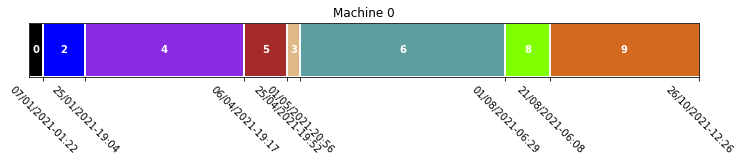

<Figure size 432x288 with 0 Axes>

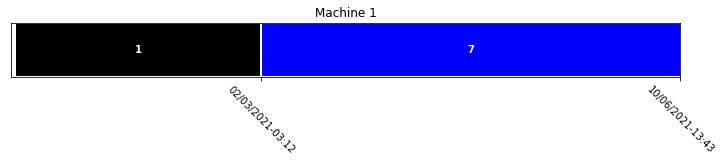

In [29]:
showEDT(machine,deb2,dem2,real2,liv2)

MARGES : 


C:\Users\Tino\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Tino\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


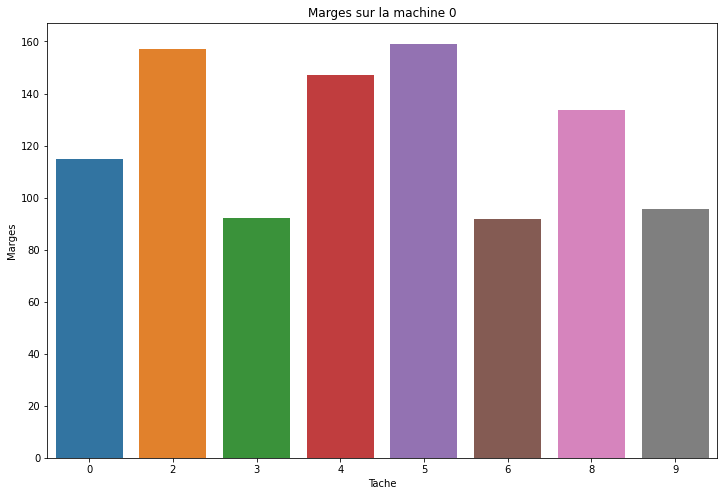

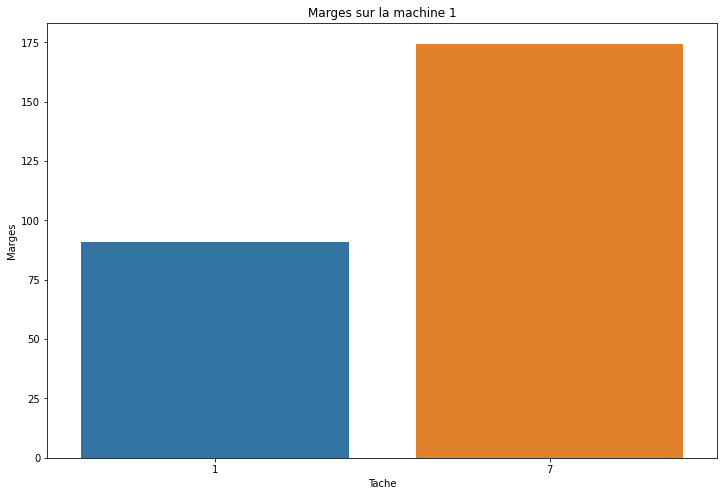

In [30]:
showMarge(machine,livVal,dmax,2)

# Main CP

In [31]:
from pulp import *
from os import dup, dup2, close
import time
import numpy as np

def solvePLNEMultiMachines_2(disp, dmax, duree,M):    
    
    BIG_M = 1e6
    
    Tasks=range(len(disp)) #Liste des taches 
    Machine=range(M)
    
    model = LpProblem("Orano", LpMaximize)
    
    # Variables 
    y = LpVariable.dicts("y",((i,m) for i in Tasks for m in Machine),0,1,LpInteger) #y_{i}^m si i est usinée sur la machine m
    x = LpVariable.dicts("x", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger) #x_{i,j}^m=1 si i est usinée avant j
    deb = LpVariable.dicts("deb", Tasks,0, None)
    dem = LpVariable.dicts("dem", Tasks,0, None)
    real = LpVariable.dicts("real", Tasks,0, None)
    marge = LpVariable.dicts("marge", Tasks,0, None)
    z3 = LpVariable.dicts("z3", ((i,j,k,m) for i in Tasks for j in Tasks for k in Tasks for m in Machine),0,1,LpInteger)
    z2 = LpVariable.dicts("z2", ((i,j,m) for i in Tasks for j in Tasks for m in Machine),0,1,LpInteger)
    liv = LpVariable.dicts("liv", Tasks,0, None)
    W = LpVariable("W", lowBound=0)
    
    # Contraintes :
    for j in Tasks:
        
        for m in Machine:
            model += x[j,j,m] == 0 
            
        model += lpSum(y[j,m] for m in Machine)==1
        model += dem[j] >= disp[j]
        model += real[j] == dem[j] + duree[j] 
        model += W <= marge[j]
        model += liv[j] == deb[j] + 30
        model += liv[j] <= dmax[j]
        model += marge[j] == dmax[j] - liv[j]  
        model += deb[j] >= real[j]
        
        for i in Tasks:
            if i != j:
                for m in Machine: 
                    model += dem[j]>= real[i]-BIG_M*(1-x[i,j,m])
                    model += z2[j,i,m] <= y[i,m]
                    model += z2[j,i,m] <= y[j,m]
                    model += z2[j,i,m] >= (y[i,m]+y[j,m])-1
                    model += z2[j,i,m] >= 0
            if i<j:
                for m in Machine:
                    model += x[i,j,m]+x[j,i,m]==z2[i,j,m]

            for k in Tasks:
                if i!=j and i!=k and j!=k:
                    for m in Machine : 
                        model += z3[i,j,k,m]<=z2[i,j,m]
                        model += z3[i,j,k,m]<=z2[i,k,m]
                        model += z3[i,j,k,m]>=(z2[i,j,m]+z2[j,k,m])-1
                        model += z3[i,j,k,m]>=0
                
    # Objectif : 
    model += W
    
    # Ouverture du fichier contenant les logs
    f = open('capture.txt', 'w')
    orig_std_out = dup(1)
    dup2(f.fileno(), 1)
    
    #Resolution du PLNE : 
    starttime=time.time() #Pour avoir le temps d'execution
    model.solve(PULP_CBC_CMD(maxSeconds=60, msg = 1))
    solveTime=time.time()-starttime
    
    # Ecriture des logs dans un fichier
    dup2(orig_std_out, 1)
    close(orig_std_out)
    f.close()
    
    #Affichage des éléments de résolution
    f_val=[]
    for i in range(0,len(Tasks)):
        f_val.append(model.variables()[i].varValue)
    order=np.argsort(f_val)
    
    print("Temps de résolution = ", solveTime)
    print("Statut de la solution = ", LpStatus[model.status])
    print("Valeur optimale = ", value(model.objective))
    return(solveTime,value(model.objective),model.variables())


In [32]:
#Importation des fonctions : 
from Solve_PLNE import solvePLNEMultiMachines
from utils import *
from graphics import *

In [33]:
# Lecture des donnees du fichier Orano-données-Double.xlsx :
data = pd.read_excel("data/raw/Orano-données-Double.xlsx", sheet_name="Optim", header=5, usecols=[3,4,5,6,7], nrows=47)

In [34]:
# Calculs des performances de chaque machines pour chaque valeur de taux d'uranium : 
predictors=perfs()

In [35]:
# conversion des données et récupération des n premieres commandes : 
n = 15
disp, dmax, duree = dataframe_to_list(data)
disp, dmax, duree = disp[:n], dmax[:n], duree[:n]

In [36]:
# Résolution du PLNE avec des valeurs aléatoires de mu : 
a=[12,-8]
np.random.seed(15)
mu=np.random.uniform(0.02,0.049,15)
[t,price,var]= solvePLNEMultiMachines(disp, dmax, duree,2,10**6,mu,a,predictors)

Temps de résolution =  53.93372678756714
Statut de la solution =  Optimal
Valeur optimale =  153240494.34671023


In [37]:
## Affichage : 

# récupération des variables du plne :
demVal,debVal,livVal,realVal,real2,dem2,deb2,liv2,machine=getValues(var,2, disp)

PLANIFICATION :


<Figure size 432x288 with 0 Axes>

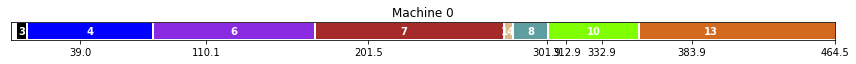

<Figure size 432x288 with 0 Axes>

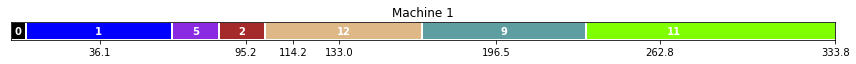

In [38]:
# Graphique représentant les emplois du temps des machines : 
showEDT(machine,deb2,dem2,real2,liv2)

MARGES : 


C:\Users\Tino\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Tino\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


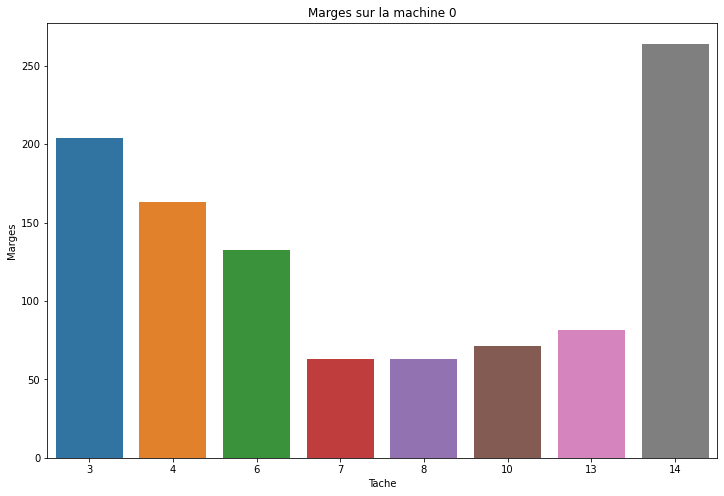

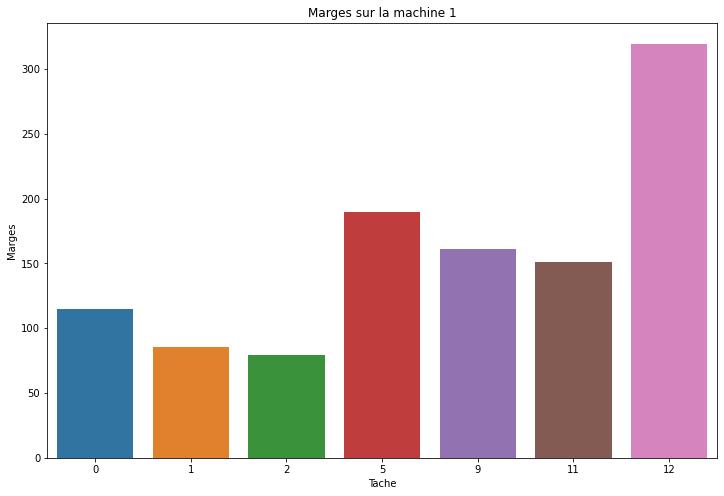

In [39]:
# Histogramme représentant la marge de chaque commande sur la machine où elle est effectuée :
showMarge(machine,livVal,dmax,2)

RENDEMENTS :


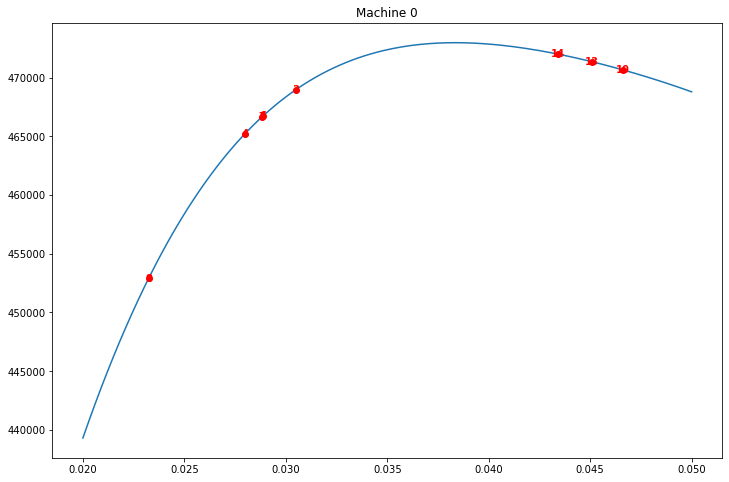

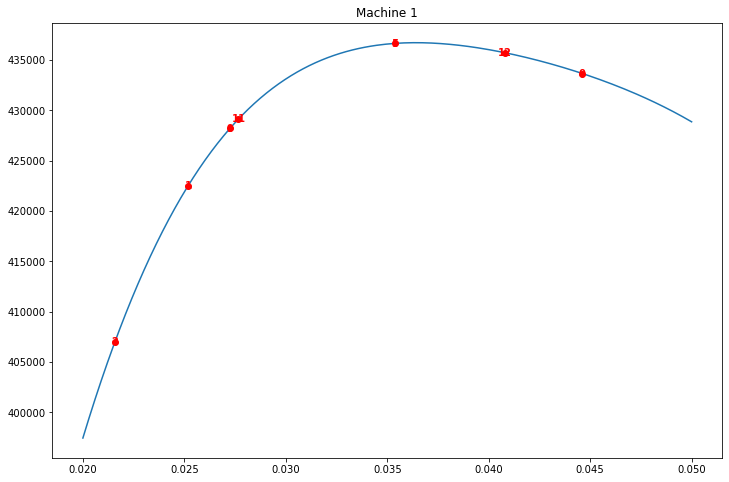

In [40]:
#Graphique représentant le rendement de la machine en fonction de la teneur en uranium désirée.
# Chaque point rouge représente une commande : 
showRendements(machine,mu,predictors)